# Pair-wise Correlations

The purpose is to identify predictor variables strongly correlated with the sales price and with each other to get an idea of what variables could be good predictors and potential issues with collinearity.

Furthermore, Box-Cox transformations and linear combinations of variables are added where applicable or useful.

## "Housekeeping"

In [1]:
import warnings
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import PowerTransformer
from tabulate import tabulate

from utils import (
    ALL_VARIABLES,
    CONTINUOUS_VARIABLES,
    DISCRETE_VARIABLES,
    NUMERIC_VARIABLES,
    ORDINAL_VARIABLES,
    TARGET_VARIABLES,
    encode_ordinals,
    load_clean_data,
    print_column_list,
)

In [2]:
pd.set_option("display.max_columns", 100)

In [3]:
sns.set_style("white")

## Load the Data

Only a subset of the previously cleaned data is used in this analysis. In particular, it does not make sense to calculate correlations involving nominal variables.

Furthermore, ordinal variables are encoded as integers (with greater values indicating a higher sales price by "guts feeling"; refer to the [data documentation](https://www.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt) to see the un-encoded values) and take part in the analysis.

A `cleaned_df` DataFrame with the original data from the previous notebook is kept so as to restore the encoded ordinal labels again at the end of this notebook for correct storage.

In [4]:
cleaned_df = load_clean_data()

In [5]:
df = cleaned_df[NUMERIC_VARIABLES + ORDINAL_VARIABLES + TARGET_VARIABLES]
df = encode_ordinals(df)

In [6]:
df[NUMERIC_VARIABLES].head()

,,1st Flr SF,2nd Flr SF,3Ssn Porch,Bedroom AbvGr,Bsmt Full Bath,Bsmt Half Bath,Bsmt Unf SF,BsmtFin SF 1,BsmtFin SF 2,Enclosed Porch,Fireplaces,Full Bath,Garage Area,Garage Cars,Gr Liv Area,Half Bath,Kitchen AbvGr,Lot Area,Low Qual Fin SF,Mas Vnr Area,Misc Val,Mo Sold,Open Porch SF,Pool Area,Screen Porch,TotRms AbvGrd,Total Bsmt SF,Wood Deck SF,Year Built,Year Remod/Add,Yr Sold
Order,PID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,526301100,1656.0,0.0,0.0,3,1,0,441.0,639.0,0.0,0.0,2,1,528.0,2,1656.0,0,1,31770.0,0.0,112.0,0.0,5,62.0,0.0,0.0,7,1080.0,210.0,1960,1960,2010
2,526350040,896.0,0.0,0.0,2,0,0,270.0,468.0,144.0,0.0,0,1,730.0,1,896.0,0,1,11622.0,0.0,0.0,0.0,6,0.0,0.0,120.0,5,882.0,140.0,1961,1961,2010
3,526351010,1329.0,0.0,0.0,3,0,0,406.0,923.0,0.0,0.0,0,1,312.0,1,1329.0,1,1,14267.0,0.0,108.0,12500.0,6,36.0,0.0,0.0,6,1329.0,393.0,1958,1958,2010
4,526353030,2110.0,0.0,0.0,3,1,0,1045.0,1065.0,0.0,0.0,2,2,522.0,2,2110.0,1,1,11160.0,0.0,0.0,0.0,4,0.0,0.0,0.0,8,2110.0,0.0,1968,1968,2010
5,527105010,928.0,701.0,0.0,3,0,0,137.0,791.0,0.0,0.0,1,2,482.0,2,1629.0,1,1,13830.0,0.0,0.0,0.0,3,34.0,0.0,0.0,6,928.0,212.0,1997,1998,2010


In [7]:
df[ORDINAL_VARIABLES].head()

,,Bsmt Cond,Bsmt Exposure,Bsmt Qual,BsmtFin Type 1,BsmtFin Type 2,Electrical,Exter Cond,Exter Qual,Fence,Fireplace Qu,Functional,Garage Cond,Garage Finish,Garage Qual,Heating QC,Kitchen Qual,Land Slope,Lot Shape,Overall Cond,Overall Qual,Paved Drive,Pool QC,Utilities
Order,PID,,,,,,,,,,,,,,,,,,,,,,,
1,526301100,4,4,3,4,1,4,2,2,0,4,7,3,3,3,1,2,2,2,4,5,1,0,3
2,526350040,3,1,3,3,2,4,2,2,3,0,7,3,1,3,2,2,2,3,5,4,2,0,3
3,526351010,3,1,3,5,1,4,2,2,0,0,7,3,1,3,2,3,2,2,5,5,2,0,3
4,526353030,3,1,3,5,1,4,2,3,0,3,7,3,3,3,4,4,2,3,4,6,2,0,3
5,527105010,3,1,4,6,1,4,2,2,3,3,7,3,3,3,3,2,2,2,4,4,2,0,3


## Linearly "dependent" Features

The "above grade (ground) living area" (= *Gr Liv Area*) can be split into 1st and 2nd floor living area plus some undefined rest.

In [8]:
assert not (
    df["Gr Liv Area"]
    != (df["1st Flr SF"] + df["2nd Flr SF"] + df["Low Qual Fin SF"])
).any()

The various basement areas also add up.

In [9]:
assert not (
    df["Total Bsmt SF"]
    != (df["BsmtFin SF 1"] + df["BsmtFin SF 2"] + df["Bsmt Unf SF"])
).any()

Calculate a variable for the total living area *Total SF* as this is the number communicated most often in housing ads.

In [10]:
df["Total SF"] = df["Gr Liv Area"] + df["Total Bsmt SF"]
new_variables = ["Total SF"]
CONTINUOUS_VARIABLES.append("Total SF")

The different porch areas are unified into a new variable *Total Porch SF*. This potentially helps making the presence of a porch in general relevant in the prediction.

In [11]:
df["Total Porch SF"] = (
    df["3Ssn Porch"] + df["Enclosed Porch"] + df["Open Porch SF"]
    + df["Screen Porch"] + df["Wood Deck SF"]
)
new_variables.append("Total Porch SF")
CONTINUOUS_VARIABLES.append("Total Porch SF")

The various types of rooms "above grade" (i.e., *TotRms AbvGrd*, *Bedroom AbvGr*, *Kitchen AbvGr*, and *Full Bath*) do not add up (only in 29% of the cases they do). Therefore, no single unified variable can be used as a predictor.

In [12]:
round(
    100
    * (
        df["TotRms AbvGrd"]
        == (df["Bedroom AbvGr"] + df["Kitchen AbvGr"] + df["Full Bath"])
    ).sum()
    / df.shape[0]
)

29

Unify the number of various types of bathrooms into a single variable. Note that "half" bathrooms are counted as such.

In [13]:
df["Total Bath"] = (
    df["Full Bath"] + 0.5 * df["Half Bath"]
    + df["Bsmt Full Bath"] + 0.5 * df["Bsmt Half Bath"]
)
new_variables.append("Total Bath")
DISCRETE_VARIABLES.append("Total Bath")

## Box-Cox Transformations

Only numeric columns with non-negative values are eligable for a Box-Cox transformation.

In [14]:
columns = CONTINUOUS_VARIABLES + TARGET_VARIABLES
transforms = df[columns].describe().T
transforms = list(transforms[transforms['min'] > 0].index)
print_column_list(transforms)

1st Flr SF   First Floor square feet
Gr Liv Area  Above grade (ground) living area square feet
Lot Area     Lot size in square feet
SalePrice
Total SF


A common convention is to use Box-Cox transformations only if the found lambda value (estimated with Maximum Likelyhood Estimation) is in the range from -3 to +3.

Consequently, the only applicable transformation are for *SalePrice* and the new variable *Total SF*.

In [15]:
# Check the Box-Cox tranformations for each column seperately
# to decide if the optimal lambda value is in an acceptable range.
output = []
transformed_columns = []
for column in transforms:
    X = df[[column]]  # 2D array needed!
    pt = PowerTransformer(method="box-cox", standardize=False)
    # Suppress a weird but harmless warning from scipy
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pt.fit(X)
    # Check if the optimal lambda is ok.
    lambda_ = pt.lambdas_[0].round(1)
    if -3 <= lambda_ <= 3:
        lambda_label = 0 if lambda_ <= 0.01 else lambda_  # to avoid -0.0
        new_column = f"{column} (box-cox-{lambda_label})"
        df[new_column] = (
            np.log(X) if lambda_ <= 0.001 else (((X ** lambda_) - 1) / lambda_)
        )
        # Track the new column in the appropiate list.
        new_variables.append(new_column)
        if column in TARGET_VARIABLES:
            TARGET_VARIABLES.append(new_column)
        else:
            CONTINUOUS_VARIABLES.append(new_column)
        # To show only the transformed columns below.
        transformed_columns.append(column)
        transformed_columns.append(new_column)
        output.append((
            f"{column}:",
            f"use lambda of {lambda_}",
        ))
    else:
        output.append((
            f"{column}:",
            f"lambda of {lambda_} not in realistic range",
        ))
print(tabulate(sorted(output), tablefmt="plain"))

1st Flr SF:   use lambda of -0.0
Gr Liv Area:  use lambda of -0.0
Lot Area:     use lambda of 0.1
SalePrice:    use lambda of 0.0
Total SF:     use lambda of 0.2


In [16]:
df[transformed_columns].head()

,,1st Flr SF,1st Flr SF (box-cox-0),Gr Liv Area,Gr Liv Area (box-cox-0),Lot Area,Lot Area (box-cox-0.1),Total SF,Total SF (box-cox-0.2),SalePrice,SalePrice (box-cox-0)
Order,PID,,,,,,,,,,
1,526301100,1656.0,7.412160,1656.0,7.412160,31770.0,18.196923,2736.0,19.344072,215000.0,12.278393
2,526350040,896.0,6.797940,896.0,6.797940,11622.0,15.499290,1778.0,17.333478,105000.0,11.561716
3,526351010,1329.0,7.192182,1329.0,7.192182,14267.0,16.027549,2658.0,19.203658,172000.0,12.055250
4,526353030,2110.0,7.654443,2110.0,7.654443,11160.0,15.396064,4220.0,21.548042,244000.0,12.404924
5,527105010,928.0,6.833032,1629.0,7.395722,13830.0,15.946705,2557.0,19.016856,189900.0,12.154253


## Correlations

The pair-wise correlations are calculated based on the type of the variables:
- **continuous** variables are assumed to be linearly related with the target and each other or not: use **Pearson's correlation coefficient**
- **discrete** (because of the low number of distinct realizations as seen in the data cleaning notebook) and **ordinal** (low number of distinct realizations as well) variables are assumed to be related in a monotonic way with the target and each other or not: use **Spearman's rank correlation coefficient**

Furthermore, for a **naive feature selection** a "rule of thumb" classification in *weak* and *strong* correlation is applied to the predictor variables. The identified variables will be used in the prediction modelling part to speed up the feature selection. A correlation between 0.33 and 0.66 is considered *weak* while a correlation above 0.66 is considered *strong* (these thresholds refer to the absolute value of the correlation). Correlations are calculated for **each** target variable (i.e., raw "SalePrice" and Box-Cox transformation thereof). Correlations below 0.1 are considered "uncorrelated".

In [17]:
strong = 0.66
weak = 0.33
uncorrelated = 0.1

Two heatmaps below (implemented in the reusable `plot_correlation` function) help visualize the correlations.

Obviously, many variables are pair-wise correlated. This could yield regression coefficients *inprecise* and not usable / interpretable. At the same time, this does not lower the predictive power of a model as a whole. In contrast to the pair-wise correlations, *multi-collinearity* is not checked here.

In [18]:
def plot_correlation(data, title):
    """Visualize a correlation matrix in a nice heatmap."""
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_title(title, fontsize=24)
    # Blank out the upper triangular part of the matrix.
    mask = np.zeros_like(data, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Use a diverging color map.
    cmap = sns.diverging_palette(240, 0, as_cmap=True)
    # Adjust the labels' font size.
    labels = data.columns
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_yticklabels(labels, fontsize=10)
    # Plot it.
    sns.heatmap(
        data, vmin=-1, vmax=1, cmap=cmap, center=0, linewidths=.5,
        cbar_kws={"shrink": .5}, square=True, mask=mask, ax=ax
    )

### Pearson

Pearson's correlation coefficient shows a linear relationship between two variables.

In [19]:
columns = CONTINUOUS_VARIABLES + TARGET_VARIABLES
pearson = df[columns].corr(method="pearson")

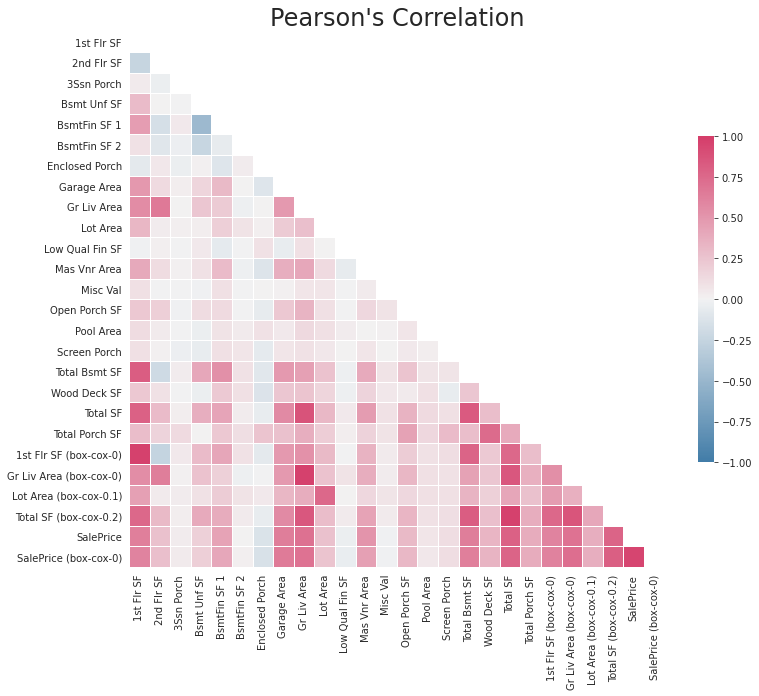

In [20]:
plot_correlation(pearson, "Pearson's Correlation")

Predictors weakly or strongly correlated with a target variable are collected.

In [21]:
pearson_weakly_correlated = set()
pearson_strongly_correlated = set()
pearson_uncorrelated = set()
# Iterate over the raw and transformed target.
for target in TARGET_VARIABLES:
    corrs = pearson.loc[target].drop(TARGET_VARIABLES).abs()
    pearson_weakly_correlated |= set(corrs[(weak < corrs) & (corrs <= strong)].index)
    pearson_strongly_correlated |= set(corrs[(strong < corrs)].index)
    pearson_uncorrelated |= set(corrs[(corrs < uncorrelated)].index)
# Show that no contradiction exists between the classifications.
assert pearson_weakly_correlated & pearson_strongly_correlated == set()
assert pearson_weakly_correlated & pearson_uncorrelated == set()

Show the continuous variables that are weakly and strongly correlated with the sales price or uncorrelated.

In [22]:
print_column_list(pearson_uncorrelated)

3Ssn Porch       Three season porch area in square feet
BsmtFin SF 2     Type 2 finished square feet
Low Qual Fin SF  Low quality finished square feet (all floors)
Misc Val         $Value of miscellaneous feature
Pool Area        Pool area in square feet


In [23]:
print_column_list(pearson_weakly_correlated)

1st Flr SF              First Floor square feet
1st Flr SF (box-cox-0)
BsmtFin SF 1            Type 1 finished square feet
Garage Area             Size of garage in square feet
Lot Area (box-cox-0.1)
Mas Vnr Area            Masonry veneer area in square feet
Total Bsmt SF           Total square feet of basement area
Total Porch SF
Wood Deck SF            Wood deck area in square feet


In [24]:
print_column_list(pearson_strongly_correlated)

Gr Liv Area              Above grade (ground) living area square feet
Gr Liv Area (box-cox-0)
Total SF
Total SF (box-cox-0.2)


### Spearman

Spearman's correlation coefficient shows an ordinal rank relationship between two variables.

In [25]:
columns = sorted(DISCRETE_VARIABLES + ORDINAL_VARIABLES) + TARGET_VARIABLES
spearman = df[columns].corr(method="spearman")

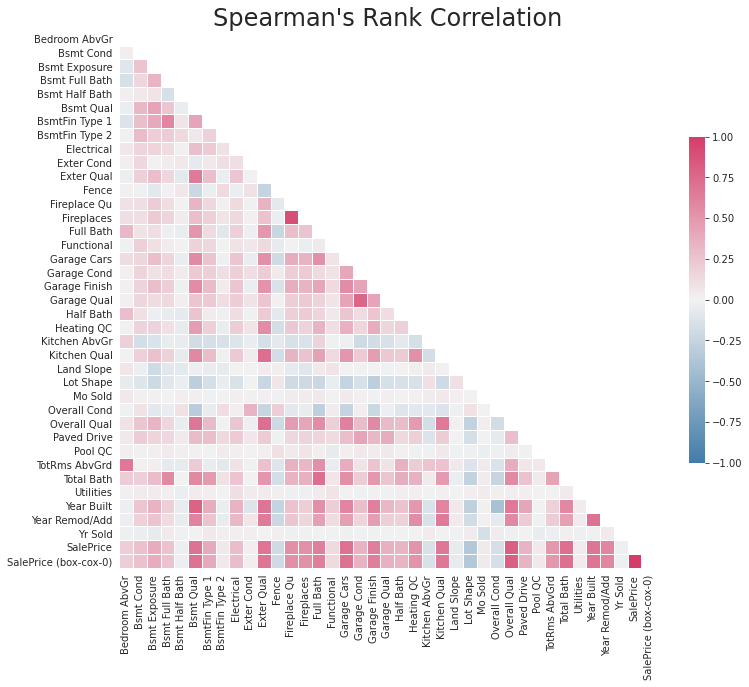

In [26]:
plot_correlation(spearman, "Spearman's Rank Correlation")

Predictors weakly or strongly correlated with a target variable are collected.

In [27]:
spearman_weakly_correlated = set()
spearman_strongly_correlated = set()
spearman_uncorrelated = set()
# Iterate over the raw and transformed target.
for target in TARGET_VARIABLES:
    corrs = spearman.loc[target].drop(TARGET_VARIABLES).abs()
    spearman_weakly_correlated |= set(corrs[(weak < corrs) & (corrs <= strong)].index)
    spearman_strongly_correlated |= set(corrs[(strong < corrs)].index)
    spearman_uncorrelated |= set(corrs[(corrs < uncorrelated)].index)
# Show that no contradiction exists between the classifications.
assert spearman_weakly_correlated & spearman_strongly_correlated == set()
assert spearman_weakly_correlated & spearman_uncorrelated == set()

Show the discrete and ordinal variables that are weakly and strongly correlated with the sales price or uncorrelated.

In [28]:
print_column_list(spearman_uncorrelated)

Bsmt Half Bath  Basement half bathrooms
BsmtFin Type 2  Rating of basement finished area (if multiple types)
Exter Cond      Evaluates the present condition of the material on the exterior
Land Slope      Slope of property
Mo Sold         Month Sold (MM)
Pool QC         Pool quality
Utilities       Type of utilities available
Yr Sold         Year Sold (YYYY)


In [29]:
print_column_list(spearman_weakly_correlated)

Bsmt Exposure   Refers to walkout or garden level walls
BsmtFin Type 1  Rating of basement finished area
Fireplace Qu    Fireplace quality
Fireplaces      Number of fireplaces
Full Bath       Full bathrooms above grade
Garage Cond     Garage condition
Garage Finish   Interior finish of the garage
Garage Qual     Garage quality
Half Bath       Half baths above grade
Heating QC      Heating quality and condition
Lot Shape       General shape of property
Paved Drive     Paved driveway
TotRms AbvGrd   Total rooms above grade (does not include bathrooms)
Year Remod/Add  Remodel date (same as construction date if no remodeling or additions)


In [30]:
print_column_list(spearman_strongly_correlated)

Bsmt Qual     Evaluates the height of the basement
Exter Qual    Evaluates the quality of the material on the exterior
Garage Cars   Size of garage in car capacity
Kitchen Qual  Kitchen quality
Overall Qual  Rates the overall material and finish of the house
Total Bath
Year Built    Original construction date


## Save the Results

### Save the weakly and strongly correlated Variables

The subset of variables that have a correlation with the house price are saved in a simple JSON file for easy re-use.

In [31]:
with open("data/correlated_variables.json", "w") as file:
    file.write(json.dumps({
        "uncorrelated": sorted(
            list(pearson_uncorrelated) + list(spearman_uncorrelated)
        ),
        "weakly_correlated": sorted(
            list(pearson_weakly_correlated) + list(spearman_weakly_correlated)
        ),
        "strongly_correlated": sorted(
            list(pearson_strongly_correlated) + list(spearman_strongly_correlated)
        ),
    }))

### Save the Data

Sort the new variables into the unprocessed `cleaned_df` DataFrame with the targets at the end. This "restores" the ordinal labels again for storage.

In [32]:
for column in new_variables:
    cleaned_df[column] = df[column]
for target in set(TARGET_VARIABLES) & set(new_variables):
    new_variables.remove(target)
cleaned_df = cleaned_df[sorted(ALL_VARIABLES + new_variables) + TARGET_VARIABLES]

In totality, this notebook added two new linear combinations and one Box-Cox transformation to the previous 78 columns.

In [33]:
cleaned_df.shape

(2898, 86)

In [34]:
cleaned_df.head()

,,1st Flr SF,1st Flr SF (box-cox-0),2nd Flr SF,3Ssn Porch,Alley,Bedroom AbvGr,Bldg Type,Bsmt Cond,Bsmt Exposure,Bsmt Full Bath,Bsmt Half Bath,Bsmt Qual,Bsmt Unf SF,BsmtFin SF 1,BsmtFin SF 2,BsmtFin Type 1,BsmtFin Type 2,Central Air,Condition 1,Condition 2,Electrical,Enclosed Porch,Exter Cond,Exter Qual,Exterior 1st,Exterior 2nd,Fence,Fireplace Qu,Fireplaces,Foundation,Full Bath,Functional,Garage Area,Garage Cars,Garage Cond,Garage Finish,Garage Qual,Garage Type,Gr Liv Area,Gr Liv Area (box-cox-0),Half Bath,Heating,Heating QC,House Style,Kitchen AbvGr,Kitchen Qual,Land Contour,Land Slope,Lot Area,Lot Area (box-cox-0.1),Lot Config,Lot Shape,Low Qual Fin SF,MS SubClass,MS Zoning,Mas Vnr Area,Mas Vnr Type,Misc Feature,Misc Val,Mo Sold,Neighborhood,Open Porch SF,Overall Cond,Overall Qual,Paved Drive,Pool Area,Pool QC,Roof Matl,Roof Style,Sale Condition,Sale Type,Screen Porch,Street,TotRms AbvGrd,Total Bath,Total Bsmt SF,Total Porch SF,Total SF,Total SF (box-cox-0.2),Utilities,Wood Deck SF,Year Built,Year Remod/Add,Yr Sold,SalePrice,SalePrice (box-cox-0)
Order,PID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,526301100,1656.0,7.412160,0.0,0.0,NA,3,1Fam,Gd,Gd,1,0,TA,441.0,639.0,0.0,BLQ,Unf,Y,Norm,Norm,SBrkr,0.0,TA,TA,BrkFace,Plywood,NA,Gd,2,CBlock,1,Typ,528.0,2,TA,Fin,TA,Attchd,1656.0,7.412160,0,GasA,Fa,1Story,1,TA,Lvl,Gtl,31770.0,18.196923,Corner,IR1,0.0,020,RL,112.0,Stone,NA,0.0,5,Names,62.0,5,6,P,0.0,NA,CompShg,Hip,Normal,WD,0.0,Pave,7,2.0,1080.0,272.0,2736.0,19.344072,AllPub,210.0,1960,1960,2010,215000.0,12.278393
2,526350040,896.0,6.797940,0.0,0.0,NA,2,1Fam,TA,No,0,0,TA,270.0,468.0,144.0,Rec,LwQ,Y,Feedr,Norm,SBrkr,0.0,TA,TA,VinylSd,VinylSd,MnPrv,NA,0,CBlock,1,Typ,730.0,1,TA,Unf,TA,Attchd,896.0,6.797940,0,GasA,TA,1Story,1,TA,Lvl,Gtl,11622.0,15.499290,Inside,Reg,0.0,020,RH,0.0,None,NA,0.0,6,Names,0.0,6,5,Y,0.0,NA,CompShg,Gable,Normal,WD,120.0,Pave,5,1.0,882.0,260.0,1778.0,17.333478,AllPub,140.0,1961,1961,2010,105000.0,11.561716
3,526351010,1329.0,7.192182,0.0,0.0,NA,3,1Fam,TA,No,0,0,TA,406.0,923.0,0.0,ALQ,Unf,Y,Norm,Norm,SBrkr,0.0,TA,TA,Wd Sdng,Wd Sdng,NA,NA,0,CBlock,1,Typ,312.0,1,TA,Unf,TA,Attchd,1329.0,7.192182,1,GasA,TA,1Story,1,Gd,Lvl,Gtl,14267.0,16.027549,Corner,IR1,0.0,020,RL,108.0,BrkFace,Gar2,12500.0,6,Names,36.0,6,6,Y,0.0,NA,CompShg,Hip,Normal,WD,0.0,Pave,6,1.5,1329.0,429.0,2658.0,19.203658,AllPub,393.0,1958,1958,2010,172000.0,12.055250
4,526353030,2110.0,7.654443,0.0,0.0,NA,3,1Fam,TA,No,1,0,TA,1045.0,1065.0,0.0,ALQ,Unf,Y,Norm,Norm,SBrkr,0.0,TA,Gd,BrkFace,BrkFace,NA,TA,2,CBlock,2,Typ,522.0,2,TA,Fin,TA,Attchd,2110.0,7.654443,1,GasA,Ex,1Story,1,Ex,Lvl,Gtl,11160.0,15.396064,Corner,Reg,0.0,020,RL,0.0,None,NA,0.0,4,Names,0.0,5,7,Y,0.0,NA,CompShg,Hip,Normal,WD,0.0,Pave,8,3.5,2110.0,0.0,4220.0,21.548042,AllPub,0.0,1968,1968,2010,244000.0,12.404924
5,527105010,928.0,6.833032,701.0,0.0,NA,3,1Fam,TA,No,0,0,Gd,137.0,791.0,0.0,GLQ,Unf,Y,Norm,Norm,SBrkr,0.0,TA,TA,VinylSd,VinylSd,MnPrv,TA,1,PConc,2,Typ,482.0,2,TA,Fin,TA,Attchd,1629.0,7.395722,1,GasA,Gd,2Story,1,TA,Lvl,Gtl,13830.0,15.946705,Inside,IR1,0.0,060,RL,0.0,None,NA,0.0,3,Gilbert,34.0,5,5,Y,0.0,NA,CompShg,Gable,Normal,WD,0.0,Pave,6,2.5,928.0,246.0,2557.0,19.016856,AllPub,212.0,1997,1998,2010,189900.0,12.154253


In [35]:
cleaned_df.to_csv("data/data_clean_with_transformations.csv")